# Formula 1 drivers' qualifying vs. race finish position comparison

At every race, drivers have to complete a qualifying lap on Saturday and race on the next day. Qualifying result will determine the position of the grid for the race. This analysis will serve the function to observe the relationship between the two-day results.

This analysis will use Formula 1 API from [Ergast](https://ergast.com/mrd/)

In [2]:
import requests as re
import pandas as pd
import json
import numpy as np
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Get qualifying positions
Using the Formula 1 API, we can query the link to get a dictionary with qualifying positions in its response. Remove unnecessary columns and check the data for missing entries (i.e. drivers did not participate in the session)

In [3]:
main_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "https://ergast.com/api/f1/2021/qualifying/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['QualifyingResults']:
            drivers.append(k['Driver']['code'])
    df['QualifyingResults'] = drivers
    df['position'] = i
    data.append(df)

main_df = main_df.append(data, True)

In [4]:
main_df = main_df[['round', 'raceName', 'QualifyingResults', 'position']]
main_df.head()

,round,raceName,QualifyingResults,position
0,1,Bahrain Grand Prix,VER,1
1,2,Emilia Romagna Grand Prix,HAM,1
2,3,Portuguese Grand Prix,BOT,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,LEC,1


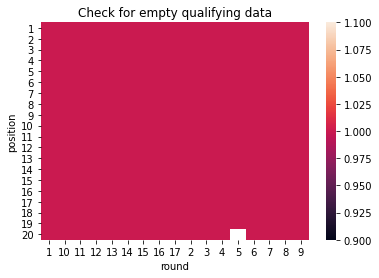

In [5]:
pivot = pd.pivot_table(main_df, values='QualifyingResults', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## 2. Get race positions
Using the similar API query, the position after the races were finished are recorded in `race_df`

In [6]:
race_df = pd.DataFrame()
data = []

for i in range(1,21):
    url = "http://ergast.com/api/f1/2021/results/" + str(i) + ".json"
    response = re.get(url)
    json = response.json()
    df = json_normalize(json['MRData']['RaceTable']['Races'])
    drivers = []
    for j in json['MRData']['RaceTable']['Races']:
        for k in j['Results']:
            drivers.append(k['Driver']['code'])
    df['Results'] = drivers
    df['position'] = i
    data.append(df)

race_df = race_df.append(data, True)

In [7]:
race_df = race_df[['round', 'raceName', 'Results', 'position']]
race_df.head()

,round,raceName,Results,position
0,1,Bahrain Grand Prix,HAM,1
1,2,Emilia Romagna Grand Prix,VER,1
2,3,Portuguese Grand Prix,HAM,1
3,4,Spanish Grand Prix,HAM,1
4,5,Monaco Grand Prix,VER,1


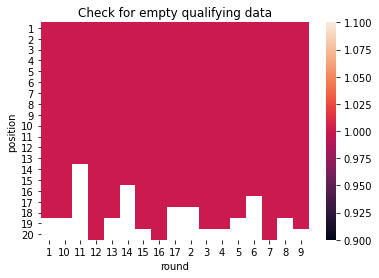

In [8]:
pivot = pd.pivot_table(race_df, values='Results', index=['position'], columns=['round'], aggfunc='count')
ax = sns.heatmap(pivot)
ax.set_title('Check for empty qualifying data');

## 3. Merge the two tables
The two data frames then are merged by indexing the driver name and round number in the qualifying result table. Missing data will be maintained as NaN

In [9]:
# renaming columns
main_df.rename(columns={'QualifyingResults':'driver', 'position': 'quali_pos'}, inplace=True)
race_df.rename(columns={'Results':'driver', 'position': 'race_pos'}, inplace=True)

In [10]:
main_df['to_match'] = main_df[['round', 'driver']].agg('-'.join, axis=1)
main_df.head()

,round,raceName,driver,quali_pos,to_match
0,1,Bahrain Grand Prix,VER,1,1-VER
1,2,Emilia Romagna Grand Prix,HAM,1,2-HAM
2,3,Portuguese Grand Prix,BOT,1,3-BOT
3,4,Spanish Grand Prix,HAM,1,4-HAM
4,5,Monaco Grand Prix,LEC,1,5-LEC


In [11]:
race_df['to_match'] = race_df[['round', 'driver']].agg('-'.join, axis=1)
race_df.head()

,round,raceName,driver,race_pos,to_match
0,1,Bahrain Grand Prix,HAM,1,1-HAM
1,2,Emilia Romagna Grand Prix,VER,1,2-VER
2,3,Portuguese Grand Prix,HAM,1,3-HAM
3,4,Spanish Grand Prix,HAM,1,4-HAM
4,5,Monaco Grand Prix,VER,1,5-VER


In [12]:
main_df = main_df.merge(race_df[['to_match','race_pos']],how='left',on='to_match')
main_df['delta'] = main_df['quali_pos'] - main_df['race_pos']
main_df.head()

,round,raceName,driver,quali_pos,to_match,race_pos,delta
0,1,Bahrain Grand Prix,VER,1,1-VER,2.0,-1.0
1,2,Emilia Romagna Grand Prix,HAM,1,2-HAM,2.0,-1.0
2,3,Portuguese Grand Prix,BOT,1,3-BOT,3.0,-2.0
3,4,Spanish Grand Prix,HAM,1,4-HAM,1.0,0.0
4,5,Monaco Grand Prix,LEC,1,5-LEC,NaN,NaN


## 4. Export to csv and chart heatmap to present findings
Create the function to compare a list of drivers. Label numbers show the count of occurence of the coordinate respectively.

- Above the diagonal line means driver **gain** position during the race
- Below the diagonal line means driver **lose** position during the race

In [13]:
# main_df.to_csv('plot.csv')

In [14]:
def compare_driver(chart_list):
    for item in chart_list:
        pivot = pd.pivot_table(main_df.loc[main_df['driver']==item], values='round', index=['race_pos'], columns=['quali_pos'], aggfunc='count')
        pivot.fillna(0, inplace=True)
        pivot = pivot.reindex(range(1,21), axis=0, fill_value=0)
        pivot = pivot.reindex(range(1,21), axis=1, fill_value=0)
        gain_avg = round(main_df.loc[main_df['driver']==item]['delta'].mean(),1)
        quali_avg = round(main_df.loc[main_df['driver']==item]['quali_pos'].mean(),1)
        race_avg = round(main_df.loc[main_df['driver']==item]['race_pos'].mean(),1)

        plt.figure(figsize=(7,5))
        ax = sns.heatmap(pivot, annot=True, mask=(pivot==0), vmin=0, vmax=3)
        ax.set(title = 'Driver: ' + item + ' - Avg pos. gained: ' + str(gain_avg),
            xlim =(0, 20), 
            ylim =(0, 20),
            autoscale_on = False)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.axline((0, 0), (1, 1), linewidth=1, color='black', alpha=0.2, dashes=(6,4))
        plt.text(12, 19, "Quali avg: " + str(quali_avg) + " / Race avg: " + str(race_avg), horizontalalignment='left', size='medium', color='black', weight='semibold')
        # plt.tight_layout()
        plt.show()

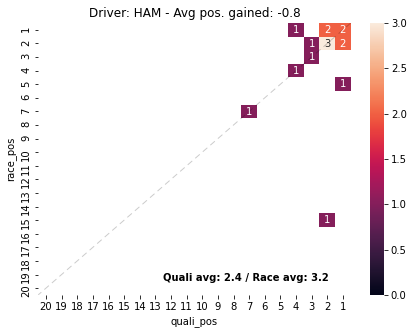

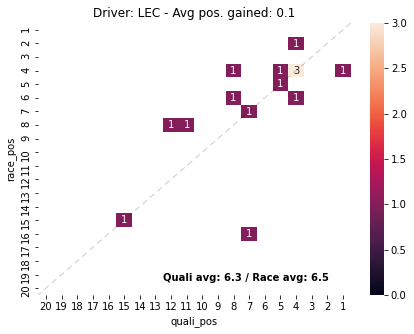

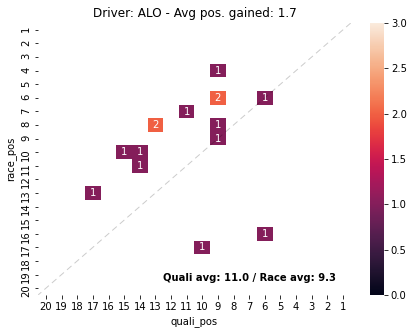

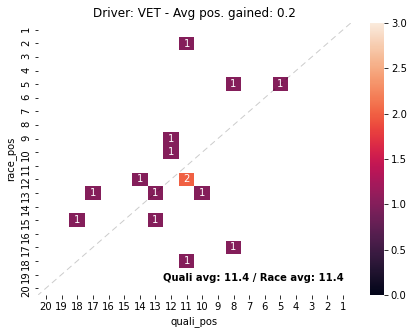

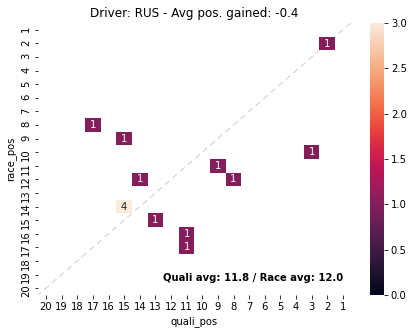

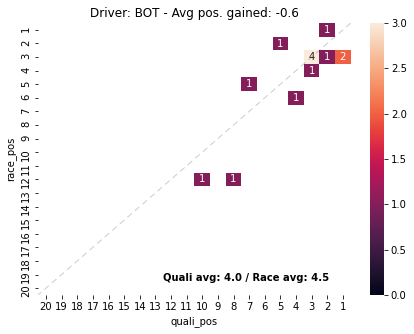

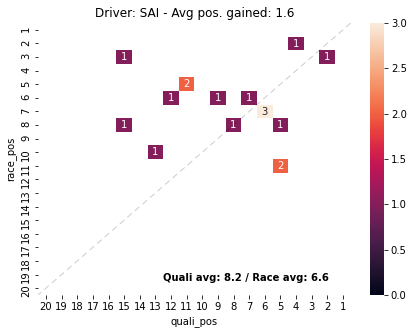

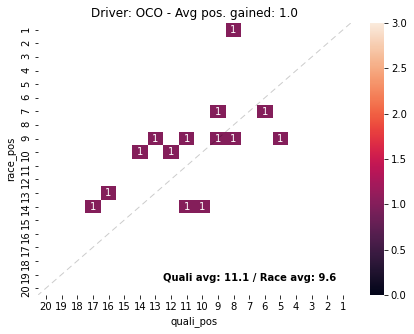

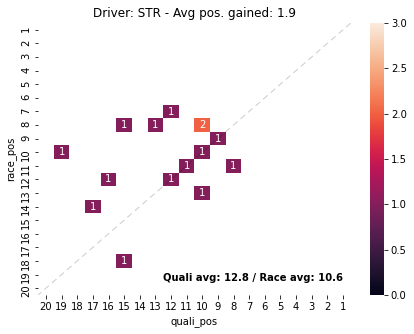

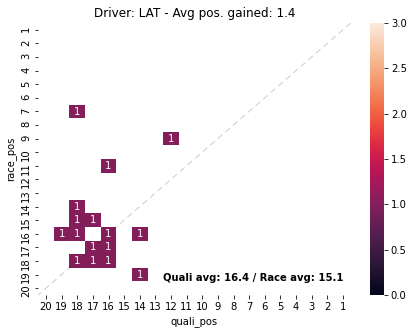

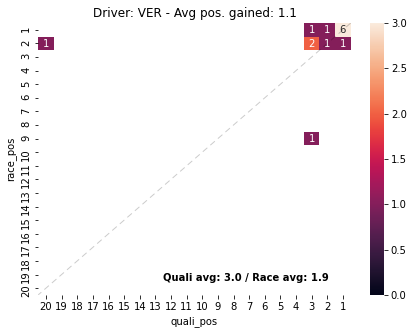

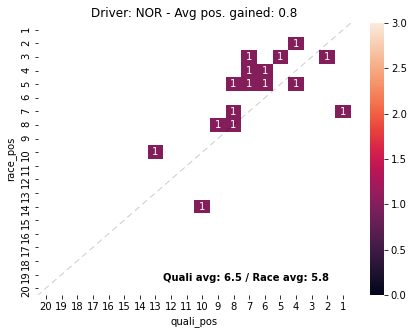

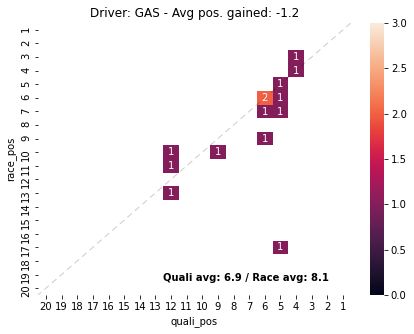

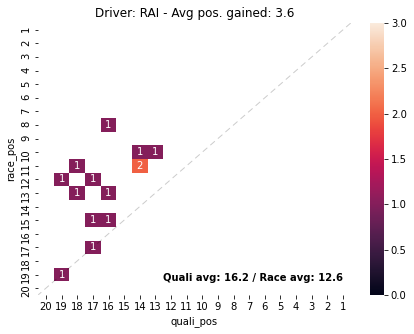

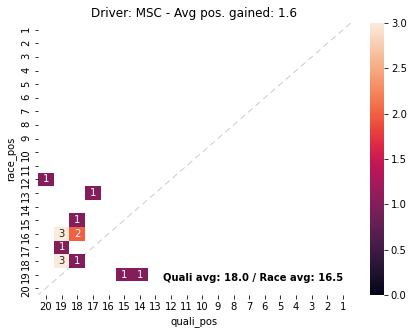

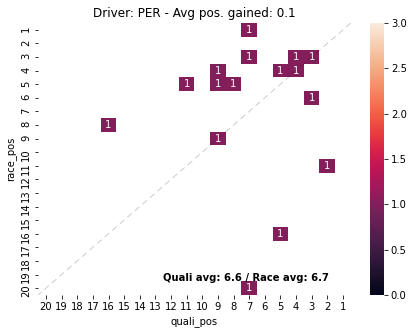

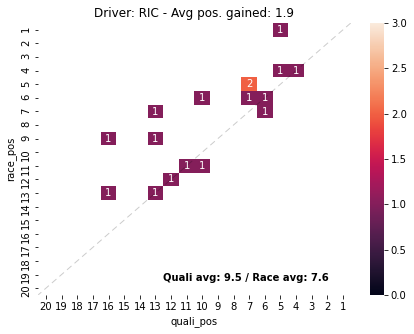

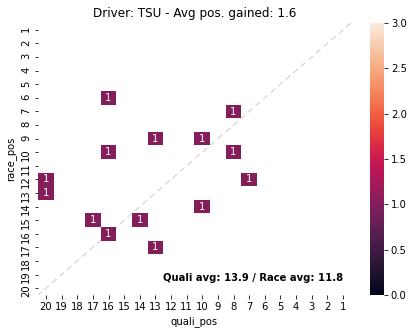

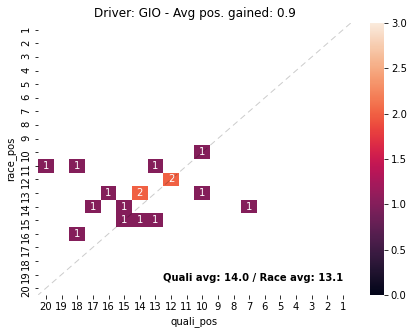

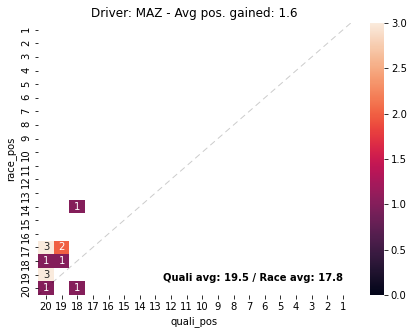

In [26]:
compare_driver(['HAM','LEC','ALO','VET','RUS'])
compare_driver(['BOT','SAI','OCO','STR','LAT'])
compare_driver(['VER','NOR','GAS','RAI','MSC'])
compare_driver(['PER','RIC','TSU','GIO','MAZ'])